# Introduction to BOBE

This notebook will introduce you to the main steps for running BOBE and interpreting the results

## Import all the relevant modules

If you want Jax to use multiple devices you need to set this before importing BOBE (as this must be done before the initial jax import when BOBE is imported)

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    os.cpu_count()
)

In [2]:
from BOBE import BOBE

/Users/nathan/Documents/GitHub/BOBEVenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:2025-12-14 14:15:07,887:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


[0: jax._src.xla_bridge] INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
[0: bo] INFO: JAX using 10 devices.


## Simple Python Function

### Define log-likelihood

The first step is to set up the likelihood function for BOBE to sample and intialise it. BOBE assumes the input is a loglikelihood.

In [45]:
import numpy as np
def banana_loglike(X):
    logpdf = -0.25 * (5 * (0.2 - X[0])) ** 2 - (20 * (X[1] / 4 - X[0] ** 4)) ** 2
    return logpdf

def prior_transform(x):
    x[0] = x[0]*2 - 1 
    x[1] = x[1]*3 - 1 
    return x

You may also want to define a prior transform function (as we have above) such that you can compare the final posteiror/evidence with another nested sampler of your choosing).

You will also need to set some parameter bounds, a list of paramters and optionally parameter labels for plotting.

In [47]:
banana_param_bounds = np.array([[-1, 1], [-1, 2]]).T
banana_param_list = ['x1', 'x2']
banana_param_labels = ['x_1', 'x_2']

### Initialise Sampler

Next we initialise BOBE with setup parameters. The BOBE object handles the specifications of the log-likelihood as well as general settings for the sampling loop.

In [40]:
sampler = BOBE(
    loglikelihood=banana_loglike,
    likelihood_name='banana', #Name for output files
    param_list=banana_param_list, # list of parameter names
    param_bounds=banana_param_bounds, # lower and upper bounds for parameters (2, ndim) shaped
    n_sobol_init=2, # number of initial Sobol samples to start the run from
    save_dir='./results', #Directory to save sampler outputs 
    save=True #This enables saving of the run at a given frequency such that a run can be restarted from a save of the GP
    resume=False, #Tells BOBE whether you'd like to resume this run from a save
    resume_file=None #Points BOBE to the run you'd like to resume from
)

[0: likelihood] INFO: Initialized loglikelihood with 2 params
[0: likelihood] INFO: Param list: ['x1', 'x2']
[0: likelihood] INFO: Param bounds: {'x1': [-1, 1], 'x2': [-1, 2]}
[0: likelihood] INFO: Logprior volume = 1.7918
[0: seed_utils] INFO: No seed provided. Generated a random seed: 1989135169
[0: seed_utils] INFO: Global random seed set to 1989135169
[0: results] INFO: Initialized BOBE results manager for 2D problem
[0: bo] INFO: Evaluating 2 Sobol initial points
[0: bo] INFO: Hyperparameters before refit: {'lengthscales': {'x1': '1.0000', 'x2': '1.0000'}, 'kernel_variance': '1.0000'}
[0: pool] INFO: Running serial GP fit with 4 restarts.
[0: bo] INFO: Hyperparameters after refit: {'lengthscales': {'x1': '0.0368', 'x2': '0.1812'}, 'kernel_variance': '1.0000'}
[0: bo] INFO: Initial best point {'x1': '0.485162', 'x2': '1.392091'} with value = -34.758347
[0: gp] INFO: Saved GP state to ./results/loglikelihood_gp.npz
[0: bo] INFO: Saving GP to file ./results/loglikelihood_gp


### Run Optimisation with convergence and run settings

Now we can run the sampler

In [41]:
results = sampler.run(
    acq='wipstd', # set acquisition function see full docs for options
    min_evals=10, # do a minimum of 10 evaluations
    max_evals=100, # max evaluation budget
    batch_size=2, # acquisition function batch size
    fit_n_points=4, # fit gp after every 4 likelihood evaluations
    ns_n_points=4, # run nested sampling after every 4 likelihood evaluations
    logz_threshold=0.1, # target logz uncertainty from GP
)

[0: bo] INFO: Iteration 1 of WIPStd, objective evals 2/100
[0: bo] INFO: Optimizing acquisition function 'WIPStd' to get next 2 points
[0: bo] INFO: Mean acquisition value 3.4146e+00 at new points
[0: bo] INFO: Evaluated objective at 2 new points
[0: bo] INFO: Refitting GP hyperparameters with 4 training points 
[0: pool] INFO: Running serial GP fit with 8 restarts.
[0: bo] INFO: Current best point {'x1': '0.485162', 'x2': '1.392091'} with value = -34.758347, found at iteration 0
[0: bo] INFO: Iteration 2 of WIPStd, objective evals 4/100
[0: bo] INFO: Optimizing acquisition function 'WIPStd' to get next 2 points
[0: bo] INFO: Mean acquisition value 2.8606e+00 at new points
[0: bo] INFO: Evaluated objective at 2 new points
[0: bo] INFO: Refitting GP hyperparameters with 6 training points 
[0: pool] INFO: Running serial GP fit with 8 restarts.
[0: bo] INFO: Current best point {'x1': '0.485162', 'x2': '1.392091'} with value = -34.758347, found at iteration 0
[0: bo] INFO: Iteration 3 of W

### Access the evidence and posterior samples

In [42]:
print(fr"Log Evidence: {results['logz']['mean']} $\pm$ {(results['logz']['upper']- results['logz']['lower'])/2}")
samples = results['samples'] # dictionary containing keys 'x', 'logl', 'weights'

Log Evidence: -3.1302321681599303 $\pm$ 0.035332983648385774


BOBE also exposes the results manager which can be used to do more in depth analysis of the run

In [ ]:
%matplotlib inline
import seaborn as sns
from getdist import MCSamples, plots
from dynesty import DynamicNestedSampler
from BOBE.utils.core import renormalise_log_weights, scale_from_unit
import matplotlib.pyplot as plt

gp = results['gp']
logz_dict = results.get('logz', {})
likelihood = results['likelihood']
results_manager = results['results_manager']
samples = results['samples']
ndim = gp.ndim

Run a nested sampler to compare log evidences

In [48]:
# Create Dynesty samples to compare against
dns_sampler =  DynamicNestedSampler(banana_loglike,prior_transform,ndim=ndim,
                                       sample='rwalk')

dns_sampler.run_nested(print_progress=False,dlogz_init=0.01) 
res = dns_sampler.results  
mean = res['logz'][-1]
logz_err = res['logzerr'][-1]

print(f"Final LogZ: {logz_dict.get('mean', 'N/A'):.4f}")
if 'upper' in logz_dict and 'lower' in logz_dict:
    print(f"LogZ uncertainty: ±{(logz_dict['upper'] - logz_dict['lower'])/2:.4f}")

print(f"Mean logz from dynesty = {mean:.4f} +/- {logz_err:.4f}")

dns_samples = res['samples']
weights = renormalise_log_weights(res['logwt'])

Final LogZ: -3.1302
LogZ uncertainty: ±0.0353
Mean logz from dynesty = -3.2340 +/- 0.0391


Use samples from the nested sampler to compare posteriors

Removed no burn in
Removed no burn in
Creating parameter samples plot...


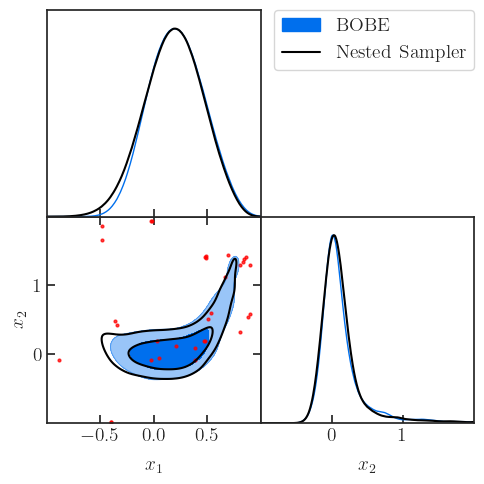

In [49]:
reference_samples = MCSamples(samples=dns_samples, names=banana_param_list, labels=banana_param_labels,
                            weights=weights, 
                            ranges= dict(zip(banana_param_list,banana_param_bounds.T)))  


# Create MCSamples from BOBE results
sample_array = samples['x']
weights_array = samples['weights']
BOBE_Samples = MCSamples(samples=sample_array, names=banana_param_list, labels=banana_param_labels,
                            weights=weights_array, 
                            ranges= dict(zip(banana_param_list,banana_param_bounds.T)))

# Create parameter samples plot
print("Creating parameter samples plot...")
sns.set_theme('notebook', 'ticks', palette='husl')
plt.rcParams['text.usetex'] = True # optional for LaTeX-style text rendering
plt.rcParams['font.family'] = 'serif'

g = plots.get_subplot_plotter(subplot_size=2.5, subplot_size_ratio=1)
g.settings.legend_fontsize = 16
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 16
g.triangle_plot([BOBE_Samples,reference_samples], filled=[True, False],
            contour_colors=['#006FED', 'black'], contour_lws=[1, 1.5],
            legend_labels=['BOBE', 'Nested Sampler']) 
# add scatter points for gp training data
points = scale_from_unit(gp.train_x, banana_param_bounds)
for i in range(ndim):
    # ax = g.subplots[i,i]
    for j in range(i+1, ndim):
        ax = g.subplots[j, i]
        ax.scatter(points[:, i], points[:, j], alpha=0.75, color='red', s=4)

Plot acquisition data

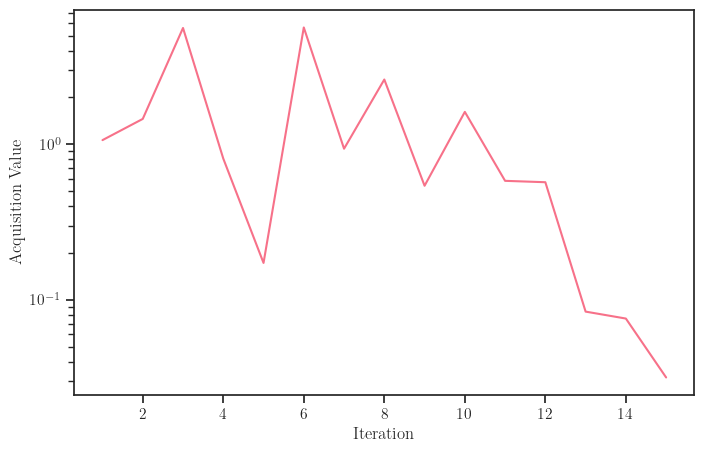

In [50]:
# Plot acquisition data
acquisition_data = results_manager.get_acquisition_data()
iterations = np.array(acquisition_data['iterations'])
values = np.array(acquisition_data['values'])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(iterations, values,  linestyle='-')
ax.set_yscale('log')
ax.set_xlabel(r'Iteration')
ax.set_ylabel(r'Acquisition Value')
plt.show()

Print a detailed timing analysis

In [51]:
print("DETAILED TIMING ANALYSIS")

timing_data = results_manager.get_timing_summary()

print(f"Automatic timing: {timing_data['total_runtime']:.2f} seconds ({timing_data['total_runtime']/60:.2f} minutes)")
print("Phase Breakdown:")
print("-" * 40)  
for phase, time_spent in timing_data['phase_times'].items():
    if time_spent > 0:
        percentage = timing_data['percentages'].get(phase, 0)
        print(f"{phase:25s}: {time_spent:8.2f}s ({percentage:5.1f}%)")


DETAILED TIMING ANALYSIS
Automatic timing: 63.44 seconds (1.06 minutes)
Phase Breakdown:
----------------------------------------
GP Training              :     9.26s ( 14.6%)
Acquisition Optimization :    23.90s ( 37.7%)
True Objective Evaluations:     0.33s (  0.5%)
Nested Sampling          :     5.57s (  8.8%)
MCMC Sampling            :    19.05s ( 30.0%)


### Cosmological Likelihood Function (with Cobaya)

For cosmological likelihoods you will need to have Cobaya installed. Once you have Cobaya installed you can simply pass the Cobaya YAML file path to the BOBE sampler in the initialisation step


In [ ]:
sampler = BOBE(
       loglikelihood='path/to/cobaya_input.yaml',
       likelihood_name='CobayaLikelihood',
       n_sobol_init=4,
       n_cobaya_init=4,  # We can also specify reference dists in the Cobaya yaml file to generate additional initial points
       likelihood_name='quickstart_cobaya_example', # name for output files
       save_dir='./results',
       use_clf=True # recommended to enable classifiers for cosmological examples where likelihood can sometimes return -inf values
   )

One can alternatively provide initialisation or 'warmstart' points to BOBE instead of using Cobaya initialisation samples. This is particularly useful for cases such as nested cosmological models but one must be careful to ensure the init_train_y are valid for the new likelihood

In [ ]:
sampler = BOBE(
       loglikelihood='path/to/cobaya_input.yaml',
       likelihood_name='CobayaLikelihood',
       n_sobol_init=4,
       init_train_x=init_train_x,
       init_train_y=init_train_y,
       likelihood_name='quickstart_cobaya_example', # name for output files
       save_dir='./results',
       use_clf=True # recommended to enable classifiers for cosmological examples where likelihood can sometimes return -inf values
   )

and then run the sampler in the same way as the first example

In [ ]:
results = sampler.run(
    acq='wipstd', # set acquisition function see full docs for options
    min_evals=10, 
    max_evals=1000 # adjust according to your evaluation budget
    batch_size=2, # acquisition function batch size
    fit_n_points=4, # fit gp after every 4 likelihood evaluations
    ns_n_points=4, # run nested sampling after every 4 likelihood evaluations
    logz_threshold=0.025, # target logz uncertainty from GP
)

The analysis is the same for both of these examples, with the exception of the posterior plots where you may want to use reference samples that have already been generated.